# Chapter 7 Variations of Policy Gradient Algorithms

This notebook was created by Chenshun Ni (nichensh@umich.edu).

## Example: Inverted Pendulum Swingup Problem - PPO-Clip and PPO-Penalty
In this notebook, we will implement the PPO-Clip and PPO-Penalty algorithms and compare their performance on solving the 'Pendulum-v1' task from the OpenAI Gym.

### Problem Description [1]

The inverted pendulum swingup problem is based on the classic problem in control theory. The system consists of a pendulum attached at one end to a fixed point, and the other end being free. The pendulum starts in a random position and the goal is to apply torque on the free end to swing it into an upright position, with its center of gravity right above the fixed point.

The diagram below specifies the coordinate system used for the implementation of the pendulum’s dynamic equations.
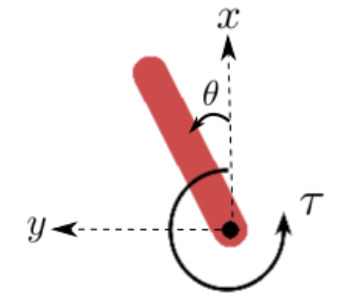

### Formulation [1]

- *State* $x$:

  The state is a ``ndarray`` with shape ``(3,)`` representing the x-y coordinates of the pendulum’s free end and its angular velocity.

  <table>
    <tr>
      <th>Num</th>
      <th>Observation</th>
      <th>Min</th>
      <th>Max</th>
    </tr>
    <tr>
      <td>0</td>
      <td>x = cos(theta)</td>
      <td>-1</td>
      <td>1</td>
    </tr>
    <tr>
      <td>1</td>
      <td>y = sin(theta)</td>
      <td>-1</td>
      <td>1</td>
    </tr>
    <tr>
      <td>2</td>
      <td>Angular Velocity</td>
      <td>-8</td>
      <td>8</td>
    </tr>
  </table>

  We can see that the state space is continuous.

- *Action* $u$:

  The action is a ``ndarray`` with shape ``(1,)`` representing the torque applied to free end of the pendulum.

  <table>
    <tr>
      <th>Num</th>
      <th>Action</th>
      <th>Min</th>
      <th>Max</th>
    </tr>
    <tr>
      <th>0</th>
      <th>Torque</th>
      <th>-2</th>
      <th>2</th>
    </tr>
  </table>

  We can see that the action space is also continuous.

- *Reward* $r$:

  The reward function is defined as

  $$
  r = -(theta^2 + 0.1 * theta\_dt^2 + 0.001 * torque^2)
  $$
  where $theta$ is the pendulum’s angle normalized between $[-\pi, \pi]$ (with 0 being in the upright position), and $theta\_dt$ is the angular velocity of the pendulum’s free end. Based on the above equation, the minimum reward that can be obtained is $-(\pi^2 + 0.1 * 8^2 + 0.001 * 2^2) = -16.2736044$, while the maximum reward is zero (pendulum is upright with zero velocity and no torque applied).

- *Starting State*:

  The starting state is a random angle in $[-\pi, \pi]$ and a random angular velocity in $[-1,1]$

- *Episode Truncation*:
  The episode truncates at 200 time steps.

- *Objective*:

  To swing the pendulum into an upright position, with its center of gravity right above the fixed point.


### PPO Algorithms

There are two forms of PPO: PPO-Penalty and PPO-Clip.

#### PPO-Penalty

The main idea of PPO-Penalty is to directly include the KL-divergence constraint into the objective function and convert the original problem into an unconstrained optimization problem, i.e.

\begin{align*}
&w^*\in \arg\max_{\tilde{w}} \mathbb{E}_{\rho_{{w}}, u\sim \pi_{{w}_k}}\left[\frac{\pi_{\tilde{w}}(u|x)}{\pi_{w_k}(u|x)} A_{w_k}(x,u)- \beta \hbox{KL}(\pi_{\tilde w}\| \pi_{w_k})\right].
\end{align*}

After obtaining $w^*,$ compute $d=\mathbb{E}_{\rho_w}\left[\hbox{KL}(\pi_{w^*}\| \pi_{w_k})\right].$
Let $\epsilon$ be a hyperparameter controlling the difference between the new policy and the old policy.
If $d\in (\epsilon/1.5, 1.5\epsilon),$ use the same $\beta$ for the next policy update. Otherwise, adjust $\beta$ such that if $d\leq \frac{\epsilon}{1.5},$ $\beta\leftarrow \beta/2,$ and if $d\geq {1.5}{\epsilon},$ $\beta\leftarrow 2\beta$.

#### PPO-Clip

PPO-clip avoids the KL divergence term and considers the following modified objective.

\begin{align*}
&\max_{\tilde{w}} \mathbb{E}_{\rho_{{w_k}}, u\sim \pi_{{w_k}}}\left[\min\left\{\frac{\pi_{\tilde{w}}(u|x)}{\pi_{w_k}(u|x)} A_{w_k}(x,u), \left(\frac{\pi_{\tilde{w}}(u|x)}{\pi_{w_k}(u|x)}\right)_{1-\epsilon}^{1+\epsilon} A_{w_k}(x,u)\right\} \right]
\end{align*}

where $\{x\}_a^b$ is the clipping function such that $\{x\}_a^b$ equals to $x$ if $x\in[a,b],$ $a$ if $x<a$ and $b$ if $x>b.$
Here $\epsilon$ is a hyperparameter controlling the clip range.
The intuition is that if $A_{w_k}(x,u)>0$ (which suggests that such state-action pair should be encouraged), the maximization operator will increase $\frac{\pi_{\tilde{w}}(u|x)}{\pi_{w_k}(u|x)}$ but it will not be larger than $1+\epsilon$. On the contrary, if $A_{w_k}(x,u)<0$ (which suggests that such state-action pair should not be encouraged), the maximization operator will decrease $\frac{\pi_{\tilde{w}}(u|x)}{\pi_{w_k}(u|x)}$, but it will not be smaller than $1-\epsilon$.


### Reference

[1] The problem description and formulation are from OpenAI Gym documentation: https://gymnasium.farama.org/environments/classic_control/pendulum/

[2] Part of the code is adapted from CleanRL repository: https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/ppo_continuous_action.py

[3] Schulman, John, et al. "Proximal policy optimization algorithms." arXiv preprint arXiv:1707.06347 (2017). https://arxiv.org/abs/1707.06347


In [ ]:
import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
from collections import deque
from statistics import mean
import matplotlib.pyplot as plt

### Define the Actor Network and the Critic Network


In [ ]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    """
    This function initializes the weights of the neural network
    """
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
      """
      This class contains the critic and actor network
      Args:
        state_dim: state dimension
        action_dim: action dimension
        hidden_dim: number of neurons in one fully connected hidden layer
      """
      super().__init__()
      """
      Structure of critic network
      """
      self.critic = nn.Sequential(
          layer_init(nn.Linear(state_dim, hidden_dim)),
          nn.ReLU(),
          layer_init(nn.Linear(hidden_dim, hidden_dim)),
          nn.ReLU(),
          layer_init(nn.Linear(hidden_dim, 1), std=1.0),
      )
      """
      Structure of actor network
      """
      self.actor_mean = nn.Sequential(
          layer_init(nn.Linear(state_dim, hidden_dim)),
          nn.ReLU(),
          layer_init(nn.Linear(hidden_dim, hidden_dim)),
          nn.ReLU(),
          layer_init(nn.Linear(hidden_dim, action_dim), std=0.01),
      )
      self.actor_logstd = nn.Parameter(torch.zeros(1, action_dim)) #std's should be independent of means

    def get_value(self, states):
        """
        The forward process of the critic network that maps state(s) -> value(s)
        Args:
          states: torch.Tensor with shape (batch_size, state_dim)
        Returns:
          values: torch.Tensor with shape (batch_size, 1)
        """
        values = self.critic(states)
        return values

    def get_mean_and_std(self, states):
        """
        The forward process of the actor network that maps state(s) -> mean(s), std(s)
        Args:
          states: torch.Tensor with shape (batch_size, state_dim)
        Returns:
          action_means: torch.Tensor with shape (batch_size, action_dim)
          action_std: torch.Tensor with shape (1, action_dim)
        """
        action_means = self.actor_mean(states)
        action_std = torch.exp(self.actor_logstd)
        return action_means, action_std

    def get_action_or_logprob(self, states, actions=None):
        """
        The forward process of the actor network that maps state(s) -> action(s)
                                      or (state(s),action(s)) -> log_prob(s)
        Args:
          states: torch.Tensor with shape (batch_size, state_dim)
          actions: torch.Tensor with shape (batch_size, action_dim)
        Returns:
          actions: torch.Tensor with shape (batch_size, action_dim)
          or
          log_probs: torch.Tensor with shape (batch_size, )
        """
        action_means = self.actor_mean(states)
        action_std = torch.exp(self.actor_logstd)
        probs = Normal(action_means, action_std + 1e-7)
        if actions is None:
            actions = probs.sample()
            return actions
        log_probs = probs.log_prob(actions).sum(1)
        entropy = probs.entropy().sum(1)
        return log_probs, entropy

### Generalized Advantage Estimation (GAE) [4]
Generalized Advantage Estimation (GAE) is a method used to estimate the advantage function $A$. Here we give a brief introduction of GAE.

We denote the temporal difference as $\delta_t=r_t+\gamma V(x_{t+1})-V(x_t)$ where $V$ is the value function. Then we have
$$
A^{(1)}_t=\delta_t=-V(x_t)+r_t+\gamma V(x_{t+1})
$$
$$
A^{(2)}_t=\delta_t+\gamma \delta_{t+1}=-V(x_t)+r_t+\gamma r_{t+1}+\gamma^2 V(x_{t+2})
$$
$$
A^{(3)}_t=\delta_t+\gamma \delta_{t+1}+\gamma^2\delta_{t+2}=-V(x_t)+r_t+\gamma r_{t+1}+\gamma^2 r_{t+2}+\gamma^2 V(x_{t+3})
$$
$$
\vdots\ \ \ \ \ \ \ \ \ \ \vdots\ \ \ \ \ \ \ \ \ \ \vdots
$$
$$
A^{(k)}_t=\sum_{l=0}^{k-1}\gamma^l\delta_{t+l}=-V(x_t)+r_t+\gamma r_{t+1}+\cdots+\gamma^{k-1}r_{t+k-1}+\gamma^k V(x_{t+k})
$$
GAE is computed as
$$
A^{GAE}_t=(1-\lambda)(A^{(1)}_t+\lambda A^{(2)}_t+\lambda^2A^{(3)}_t+\cdots)
$$
$$
=\sum_{l=0}^{\infty}(\gamma\lambda)^l\delta_{t+l}
$$
Here $\lambda\in[0,1]$ is another hyperparameter introduced in the calculation of GAE. When $\lambda=0$, $A^{GAE}_t=\delta_t=r_t+\gamma V(x_{t+1})-V(x_t)$ which is the one-step temperal difference estimation of $A_t$. When $\lambda=1$, $A^{GAE}_t=\sum_{l=0}^{\infty}\gamma^l\delta_{t+l}=\sum_{l=0}^{\infty}\gamma^lr_{t+l}-V(x_t)$ which is the complete estimation of $A_t$.

### Reference

[4] Schulman, John, et al. "High-dimensional continuous control using generalized advantage estimation." arXiv preprint arXiv:1506.02438 (2015).
https://arxiv.org/abs/1506.02438

In [ ]:
def compute_advantage(gamma, lmbda, rewards, values, next_values, dones):
  """
  This method is an implementation of the Generalized Advantage Estimation (GAE)
  Args:
    gamma: float
    lambda: float
    rewards: torch.Tensor of shape (batch_size, 1)
    values: torch.Tensor of shape (batch_size, 1)
    next_values: torch.Tensor of shape (batch_size, 1)
    dones: torch.Tensor of shape (batch_size, 1)
  Returns:
    advantages: torch.Tensor of shape (batch_size, 1)
  """
  advantages = torch.zeros_like(rewards)
  num_steps = advantages.shape[0]
  lastgaelam = 0
  for t in reversed(range(num_steps)):
      if t == num_steps - 1:
          nextnonterminal = 1.0 - dones[t]
          nextvalues = next_values[t]
      else:
          nextnonterminal = 1.0 - dones[t + 1]
          nextvalues = values[t + 1]
      delta = rewards[t] + gamma * nextvalues * nextnonterminal - values[t]
      advantages[t] = lastgaelam = delta + gamma * lmbda * nextnonterminal * lastgaelam
  return advantages

## PPO-Clip

The following Python class ``PPOAgent_Clip`` implements the PPO-Clip algorithm.

In [ ]:
class PPOAgent_Clip():
  def __init__(self, state_dim, action_dim, hidden_dim, gamma, lmbda, clip_coef, vloss_coef, learning_rate, num_epochs, num_minibatches, device, max_grad_norm, ent_coef):
    self.state_dim = state_dim
    self.action_dim = action_dim
    self.hidden_dim = hidden_dim
    self.gamma = gamma # discount factor
    self.lmbda = lmbda # hyperparameter for GAE
    self.clip_coef = clip_coef # clip coefficient for PPO
    self.vloss_coef = vloss_coef # weight assigned to value loss in the estimation of total loss
    self.learning_rate = learning_rate

    self.num_epochs = num_epochs # number of epochs for each trajectory
    self.num_minibatches = num_minibatches # number of minibatches for each epoch
    self.device = device

    self.actor_critic = ActorCritic(state_dim, action_dim, hidden_dim).to(self.device)
    self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=learning_rate, eps=1e-5)
    self.max_grad_norm = max_grad_norm
    self.ent_coef = ent_coef

  def set_ent_coef(self, ent_coef):
    self.ent_coef = ent_coef

  def train(self, train_data):
    """
    states: torch.Tensor with shape (self.batch_size, state_size), a mini-batch of current states
    actions: torch.Tensor with shape (self.batch_size, action_size), a mini-batch of current actions
    rewards: torch.Tensor with shape (self.batch_size, 1), a mini-batch of rewards
    next_states: torch.Tensor with shape (self.batch_size, state_size), a mini-batch of next states
    dones: torch.Tensor with shape (self.batch_size, 1), a mini-batch of 0-1 integers,
            where 1 means the episode terminates for that sample;
                0 means the episode does not terminate for that sample.
    """
    states = torch.tensor(np.array(train_data['states']), dtype=torch.float).reshape(-1, state_dim).to(self.device) #(B, state_size)
    actions = torch.tensor(np.array(train_data['actions']), dtype=torch.float).reshape(-1, action_dim).to(self.device) #(B, action_size)
    rewards = torch.tensor(np.array(train_data['rewards']), dtype=torch.float).reshape(-1, 1).to(self.device)  #(B, 1)
    next_states = torch.tensor(np.array(train_data['next_states']), dtype=torch.float).reshape(-1, state_dim).to(self.device) #(B, state_size)
    dones = torch.tensor(np.array(train_data['dones']), dtype=torch.float).reshape(-1, 1).to(self.device) #(B, 1)

    values = self.actor_critic.get_value(states).detach().squeeze(1)
    next_values = self.actor_critic.get_value(next_states).detach().squeeze(1)
    advantages = compute_advantage(self.gamma, self.lmbda, rewards, values, next_values, dones).to(self.device)

    advantages = advantages.reshape(-1) # flatten the advantages
    values = values.reshape(-1) # flatten the values

    old_logprobs, _ = self.actor_critic.get_action_or_logprob(states, actions)
    old_logprobs = old_logprobs.detach()

    batch_size = states.shape[0]
    b_inds = np.arange(batch_size)
    for epoch in range(self.num_epochs):
      np.random.shuffle(b_inds) # shuffle the index of training data for sampling
      minibatch_size = int(batch_size // self.num_minibatches)
      for start in range(0, batch_size, minibatch_size):
        end = start + minibatch_size
        mb_inds = b_inds[start:end] # index of the training data in the minibatch

        new_logprobs, entropy = self.actor_critic.get_action_or_logprob(states[mb_inds], actions[mb_inds])
        logratio = new_logprobs - old_logprobs[mb_inds]
        ratio = logratio.exp()

        mb_advantages = advantages[mb_inds]
        mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8) # normalize the advantages
        policy_loss1 = -mb_advantages * ratio # unclipped loss
        policy_loss2 = -mb_advantages * torch.clamp(ratio, 1 - self.clip_coef, 1 + self.clip_coef) # clipped loss
        policy_loss = torch.max(policy_loss1, policy_loss2).mean() # policy loss

        newvalues = self.actor_critic.get_value(states[mb_inds]).reshape(-1)
        returns = values[mb_inds] + advantages[mb_inds] # targets of the value function
        value_loss = 0.5 * ((newvalues - returns) ** 2).mean() # value function loss

        entropy_loss = entropy.mean()
        loss = policy_loss - self.ent_coef * entropy_loss + self.vloss_coef * value_loss # total loss

        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.actor_critic.parameters(), self.max_grad_norm)
        self.optimizer.step()


## PPO-Penalty
The following Python class ``PPOAgent_Penalty`` implements the PPO-Penalty algorithm.

In [ ]:
class PPOAgent_Penalty():
  def __init__(self, state_dim, action_dim, hidden_dim, gamma, lmbda, vloss_coef, beta, epsilon, learning_rate, num_epochs, num_minibatches, device, max_grad_norm, ent_coef):
    self.state_dim = state_dim
    self.action_dim = action_dim
    self.hidden_dim = hidden_dim
    self.gamma = gamma # discount factor
    self.lmbda = lmbda # hyperparameter for GAE
    self.vloss_coef = vloss_coef
    self.beta = beta # initialization of beta
    self.epsilon = epsilon # hyperparameter used to compare with KL divergence
    self.learning_rate = learning_rate

    self.num_epochs = num_epochs
    self.num_minibatches = num_minibatches
    self.device = device

    self.actor_critic = ActorCritic(state_dim, action_dim, hidden_dim).to(self.device)
    self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=learning_rate, eps=1e-5)
    self.max_grad_norm = max_grad_norm
    self.ent_coef = ent_coef

  def set_ent_coef(self, ent_coef):
    self.ent_coef = ent_coef

  def train(self, train_data):
    """
    states: torch.Tensor with shape (self.batch_size, state_size), a mini-batch of current states
    actions: torch.Tensor with shape (self.batch_size, action_size), a mini-batch of current actions
    rewards: torch.Tensor with shape (self.batch_size, 1), a mini-batch of rewards
    next_states: torch.Tensor with shape (self.batch_size, state_size), a mini-batch of next states
    dones: torch.Tensor with shape (self.batch_size, 1), a mini-batch of 0-1 integers,
            where 1 means the episode terminates for that sample;
                0 means the episode does not terminate for that sample.
    """
    states = torch.tensor(np.array(train_data['states']), dtype=torch.float).reshape(-1, state_dim).to(self.device) #(B, state_size)
    actions = torch.tensor(np.array(train_data['actions']), dtype=torch.float).reshape(-1, action_dim).to(self.device) #(B, action_size)
    rewards = torch.tensor(np.array(train_data['rewards']), dtype=torch.float).reshape(-1, 1).to(self.device)  #(B, 1)
    next_states = torch.tensor(np.array(train_data['next_states']), dtype=torch.float).reshape(-1, state_dim).to(self.device) #(B, state_size)
    dones = torch.tensor(np.array(train_data['dones']), dtype=torch.float).reshape(-1, 1).to(self.device) #(B, 1)

    values = self.actor_critic.get_value(states).detach().squeeze(1)
    next_values = self.actor_critic.get_value(next_states).detach().squeeze(1)
    advantages = compute_advantage(self.gamma, self.lmbda, rewards, values, next_values, dones).to(self.device)

    advantages = advantages.reshape(-1) # flatten the advantages
    values = values.reshape(-1) # flatten the values

    with torch.no_grad():
      old_logprobs, _ = self.actor_critic.get_action_or_logprob(states, actions)
      old_logprobs = old_logprobs.detach()

      old_means, old_std = self.actor_critic.get_mean_and_std(states)

    batch_size = states.shape[0]
    b_inds = np.arange(batch_size)
    for epoch in range(self.num_epochs):
      np.random.shuffle(b_inds)
      minibatch_size = int(batch_size // self.num_minibatches)
      for start in range(0, batch_size, minibatch_size):
        end = start + minibatch_size
        mb_inds = b_inds[start:end]

        new_logprobs, entropy = self.actor_critic.get_action_or_logprob(states[mb_inds], actions[mb_inds])
        logratio = new_logprobs - old_logprobs[mb_inds]
        ratio = logratio.exp()

        mb_advantages = advantages[mb_inds]
        mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8) # normalize the advantages
        policy_loss1 = mb_advantages * ratio
        old_dists = Normal(old_means[mb_inds], old_std)
        new_means, new_std = self.actor_critic.get_mean_and_std(states[mb_inds])
        new_dists = Normal(new_means, new_std)
        policy_loss2 = torch.distributions.kl.kl_divergence(old_dists, new_dists).sum(1) # estimation of the KL divergence term
        policy_loss = -(policy_loss1 - self.beta * policy_loss2).mean() # policy loss

        newvalues = self.actor_critic.get_value(states[mb_inds]).reshape(-1)
        returns = values[mb_inds] + advantages[mb_inds] # targets of the value function
        value_loss = 0.5 * ((newvalues - returns) ** 2).mean() # value function loss

        entropy_loss = entropy.mean()
        loss = policy_loss - self.ent_coef * entropy_loss + self.vloss_coef * value_loss # total loss

        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.actor_critic.parameters(), self.max_grad_norm)
        self.optimizer.step()

    new_means, new_std = self.actor_critic.get_mean_and_std(states)
    new_dists = Normal(new_means, new_std)
    old_dists = Normal(old_means, old_std)
    kl = torch.distributions.kl.kl_divergence(old_dists, new_dists).sum(1).mean()
    if kl >= 1.5*self.epsilon:
        self.beta *= 2
    if kl <= self.epsilon/1.5:
        self.beta *= 0.5

## Online Training Processes of PPO-Clip and Clip-Penalty

In [ ]:
# The following code is the online training process of PPO-Clip in the 'Pendulum-v1' gym environment.
env_name = 'Pendulum-v1'
num_episode = 1000
gamma = 0.9
lmbda = 0.95
clip_coef = 0.05
vloss_coef = 0.5
learning_rate = 3e-4
num_epochs = 10
num_minibatches = 4
max_grad_norm = 5.0
ent_coef = 0.0
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
env = gym.make(env_name)
env.reset(seed=seed)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 64

agent_clip = PPOAgent_Clip(state_dim, action_dim, hidden_dim, gamma, lmbda, clip_coef, vloss_coef, learning_rate, num_epochs, num_minibatches, device, max_grad_norm, ent_coef)

episode_return_list = []
episode_return_deque = deque(maxlen=100)
moving_avg_clip = []
for episode in range(num_episode):
  episodic_return = 0
  timestep_for_cur_episode = 0
  train_data = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
  state = env.reset()
  done = False
  while not done:
    action = agent_clip.actor_critic.get_action_or_logprob(torch.Tensor(state).to(device))
    next_state, reward, done, info = env.step(action.cpu().numpy()[0])
    train_data['states'].append(state)
    train_data['actions'].append(action)
    train_data['next_states'].append(next_state)
    train_data['rewards'].append(reward)
    train_data['dones'].append(done)
    episodic_return += reward
    timestep_for_cur_episode += 1
    if done:
      break
    state = next_state.reshape(-1)
  agent_clip.train(train_data)

  episode_return_list.append(episodic_return)
  episode_return_deque.append(episodic_return)
  print('Ep. {}, Episode Return: {}'.format(episode + 1, episodic_return), end='')

  if len(episode_return_deque) == 100:
      # Mean of last 100 episodes
      avg_reward = sum(episode_return_deque) / 100
      moving_avg_clip.append(avg_reward)
      print(', Moving Average Reward: {}'.format(avg_reward))
  else:
      print('')

returns_clip = episode_return_list

In [ ]:
# The following code is the online training process of PPO-Penalty in the 'Pendulum-v1' gym environment.
env_name = 'Pendulum-v1'
num_episode = 1000
gamma = 0.9
lmbda = 0.95
vloss_coef = 0.5
beta = 1
epsilon = 0.001
learning_rate = 3e-4
num_epochs = 10
num_minibatches = 4
max_grad_norm = 5.0
ent_coef = 0.0
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
env = gym.make(env_name)
env.reset(seed=seed)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 64

agent_penalty = PPOAgent_Penalty(state_dim, action_dim, hidden_dim, gamma, lmbda, vloss_coef, beta, epsilon, learning_rate, num_epochs, num_minibatches, device, max_grad_norm, ent_coef)

episode_return_list = []
episode_return_deque = deque(maxlen=100)
moving_avg_penalty = []
for episode in range(num_episode):
  episodic_return = 0
  timestep_for_cur_episode = 0
  train_data = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
  state = env.reset()
  done = False
  while not done:
    action = agent_penalty.actor_critic.get_action_or_logprob(torch.Tensor(state).to(device))
    next_state, reward, done, info = env.step(action.cpu().numpy()[0])
    train_data['states'].append(state)
    train_data['actions'].append(action)
    train_data['next_states'].append(next_state)
    train_data['rewards'].append(reward)
    train_data['dones'].append(done)
    episodic_return += reward
    timestep_for_cur_episode += 1
    if done:
      break
    state = next_state.reshape(-1)
  agent_penalty.train(train_data)

  episode_return_list.append(episodic_return)
  episode_return_deque.append(episodic_return)
  print('Ep. {}, Episode Return: {}'.format(episode + 1, episodic_return), end='')

  if len(episode_return_deque) == 100:
      # Mean of last 100 episodes
      avg_reward = sum(episode_return_deque) / 100
      moving_avg_penalty.append(avg_reward)
      print(', Moving Average Reward: {}'.format(avg_reward))
  else:
      print('')

returns_penalty = episode_return_list

## Comparison of the Performances of PPO-Clip and Clip-Penalty

In [ ]:
# Comparison
# Plotting reward vs episode for PPO-Clip and PPO-Penalty
plt.figure(1)
plt.plot(returns_clip, label='PPO-Clip')
plt.plot(returns_penalty, label='PPO-Penalty')
# plt.title("PPO-Clip vs PPO-Penalty")
plt.xlabel('Episode')
plt.ylabel('Total reward in each episode')
plt.legend()

# Plotting moving average of reward vs episode for PPO-Clip and PPO-Penalty
plt.figure(2)
plt.plot(moving_avg_clip, label='PPO-Clip')
plt.plot(moving_avg_penalty, label='PPO-Penalty')
# plt.title("PPO-Clip vs PPO-Penalty")
plt.xlabel('Episode')
plt.ylabel('Moving average of reward')
plt.legend()

# Show the figure
plt.show()

## Evaluation of the Two Policies Trained by PPO-Clip and PPO-Penalty

In [ ]:
# The following code is the evaluation process of PPO-Clip in the 'Pendulum-v1' gym environment.
env_name = 'Pendulum-v1'
num_episode = 100
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
env = gym.make(env_name)
env.reset(seed=seed)

episode_return_list = []
for episode in range(num_episode):
  episodic_return = 0
  state = env.reset()
  done = False
  while not done:
    action = agent_clip.actor_critic.get_action_or_logprob(torch.Tensor(state).to(device))
    next_state, reward, done, info = env.step(action.cpu().numpy()[0])
    episodic_return += reward
    if done:
      break
    state = next_state.reshape(-1)

  episode_return_list.append(episodic_return)
  print('Ep. {}, Episode Return: {}'.format(episode + 1, episodic_return))

returns_clip = episode_return_list
avg_return_clip = mean(returns_clip)

In [ ]:
# The following code is the evaluation process of PPO-Penalty in the 'Pendulum-v1' gym environment.
env_name = 'Pendulum-v1'
num_episode = 100
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
env = gym.make(env_name)
env.reset(seed=seed)

episode_return_list = []
for episode in range(num_episode):
  episodic_return = 0
  state = env.reset()
  done = False
  while not done:
    action = agent_penalty.actor_critic.get_action_or_logprob(torch.Tensor(state).to(device))
    next_state, reward, done, info = env.step(action.cpu().numpy()[0])
    episodic_return += reward
    if done:
      break
    state = next_state.reshape(-1)

  episode_return_list.append(episodic_return)
  print('Ep. {}, Episode Return: {}'.format(episode + 1, episodic_return))

returns_penalty = episode_return_list
avg_return_penalty = mean(returns_penalty)

In [ ]:
print("The per-episode return averaged over 100 episode:")
print("PPO-Clip:", avg_return_clip)
print("PPO-Penalty:", avg_return_penalty)

## Rendering the Pendulum Using Two Policies Trained by PPO-Clip and PPO-Penalty

In [ ]:
# install required packages
!apt-get update
!apt-get install -y xvfb libgtk-3-dev
!apt-get autoremove -y
!pip install pyvirtualdisplay==2.2
!pip install pyppeteer>=0.2.2
!pip install pyopengl>=3.1.5
!pip install pygame
!pyppeteer-install

In [ ]:
# Import required packages
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

In [ ]:
# Rendering the pendulum using PPO-Clip for 5 episodes
display = Display(visible=False, size=(3, 4))
_ = display.start()

env_name = 'Pendulum-v1'
num_episode = 5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
env = gym.make(env_name)
env.reset(seed=seed)

img = plt.imshow(env.render(mode='rgb_array'))

for episode in range(num_episode):
  state = env.reset()
  done = False
  while not done:
    img.set_data(env.render(mode='rgb_array'))
    ipythondisplay.display(plt.gcf())
    ipythondisplay.clear_output(wait=True)

    action = agent_clip.actor_critic.get_action_or_logprob(torch.Tensor(state).to(device))
    next_state, reward, done, info = env.step(action.cpu().numpy()[0])
    if done:
      break
    state = next_state.reshape(-1)

In [ ]:
# Rendering the pendulum using PPO-Penalty for 5 episodes
display = Display(visible=False, size=(3, 4))
_ = display.start()

env_name = 'Pendulum-v1'
num_episode = 5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
env = gym.make(env_name)
env.reset(seed=seed)

img = plt.imshow(env.render(mode='rgb_array'))

for episode in range(num_episode):
  state = env.reset()
  done = False
  while not done:
    img.set_data(env.render(mode='rgb_array'))
    ipythondisplay.display(plt.gcf())
    ipythondisplay.clear_output(wait=True)

    action = agent_penalty.actor_critic.get_action_or_logprob(torch.Tensor(state).to(device))
    next_state, reward, done, info = env.step(action.cpu().numpy()[0])
    if done:
      break
    state = next_state.reshape(-1)

env.close()
_ = display.stop()